# Automobile Data Wrangling and Analysis

This notebook performs comprehensive analysis of automobile data including:
- Data loading and cleaning
- Exploratory data analysis
- Statistical analysis and correlations
- Advanced visualizations
- Feature engineering
- Missing data analysis

**Author:** Yash Patil

## 1. Import Libraries and Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
import os

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Create organized results directories
base_dir = os.path.dirname(os.getcwd())
results_dir = os.path.join(base_dir, "results")
viz_dir = os.path.join(results_dir, "visualizations")
data_dir = os.path.join(results_dir, "processed_data")
reports_dir = os.path.join(results_dir, "reports")

for directory in [results_dir, viz_dir, data_dir, reports_dir]:
    os.makedirs(directory, exist_ok=True)

print("Setup complete!")
print(f"Results will be saved to: {results_dir}")

Setup complete!
Results will be saved to: E:\PythonProjects\PA-Projects\Automobile_Data_Wrangling_Analysis\results


## 2. Data Loading

In [2]:
def load_automobile_data():
    """Load automobile dataset from UCI repository."""
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data"
    
    # Column names based on UCI dataset documentation
    column_names = [
        "symboling", "normalized-losses", "make", "fuel-type", "aspiration", 
        "num-of-doors", "body-style", "drive-wheels", "engine-location",
        "wheel-base", "length", "width", "height", "curb-weight", 
        "engine-type", "num-of-cylinders", "engine-size", "fuel-system", 
        "bore", "stroke", "compression-ratio", "horsepower", "peak-rpm", 
        "city-mpg", "highway-mpg", "price"
    ]
    
    df = pd.read_csv(url, header=None, names=column_names)
    return df

# Load the data
df = load_automobile_data()

print(f"Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"Columns: {len(df.columns)} features")
df.head()

Dataset loaded successfully!
Shape: (205, 26)
Columns: 26 features


,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


## 3. Data Cleaning and Preprocessing

In [3]:
# Create a copy for cleaning
df_clean = df.copy()

print("Original data info:")
print(f"Shape: {df_clean.shape}")
print(f"Data types: {df_clean.dtypes.value_counts()}")

# Check for missing values represented as '?'
print("\nColumns with '?' values:")
for col in df_clean.columns:
    question_count = (df_clean[col] == '?').sum()
    if question_count > 0:
        print(f"{col}: {question_count} missing values")

Original data info:
Shape: (205, 26)
Data types: object     16
int64       5
float64     5
Name: count, dtype: int64

Columns with '?' values:
normalized-losses: 41 missing values
num-of-doors: 2 missing values
bore: 4 missing values
stroke: 4 missing values
horsepower: 2 missing values
peak-rpm: 2 missing values
price: 4 missing values


In [4]:
# Replace '?' with NaN
df_clean = df_clean.replace('?', np.nan)

# Convert numeric columns
numeric_columns = [
    'symboling', 'normalized-losses', 'wheel-base', 'length', 'width', 
    'height', 'curb-weight', 'engine-size', 'bore', 'stroke', 
    'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg', 
    'highway-mpg', 'price'
]

for col in numeric_columns:
    if col in df_clean.columns:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

# Convert fuel efficiency from MPG to L/100km for international standard
df_clean['city-L/100km'] = 235 / df_clean['city-mpg']
df_clean['highway-L/100km'] = 235 / df_clean['highway-mpg']

# Create price categories
df_clean['price_category'] = pd.cut(df_clean['price'], 
                                   bins=[0, 10000, 20000, 50000], 
                                   labels=['Budget', 'Mid-range', 'Luxury'])

print("Data cleaning completed!")
print(f"Final shape: {df_clean.shape}")
print(f"\nMissing values per column:")
missing_summary = df_clean.isnull().sum().sort_values(ascending=False)
print(missing_summary[missing_summary > 0])

Data cleaning completed!
Final shape: (205, 29)

Missing values per column:
normalized-losses    41
price_category        4
price                 4
bore                  4
stroke                4
num-of-doors          2
peak-rpm              2
horsepower            2
dtype: int64


## 4. Exploratory Data Analysis

In [5]:
# Basic statistics
categorical_cols = df_clean.select_dtypes(include=['object']).columns
numerical_cols = df_clean.select_dtypes(include=[np.number]).columns

print(f"Dataset Overview:")
print(f"Shape: {df_clean.shape}")
print(f"Categorical columns: {len(categorical_cols)}")
print(f"Numerical columns: {len(numerical_cols)}")

# Show top categorical summaries
for col in ['make', 'body-style', 'fuel-type']:
    print(f"\n{col.upper()} - Top 5:")
    print(df_clean[col].value_counts().head())

Dataset Overview:
Shape: (205, 29)
Categorical columns: 10
Numerical columns: 18

MAKE - Top 5:
make
toyota        32
nissan        18
mazda         17
mitsubishi    13
honda         13
Name: count, dtype: int64

BODY-STYLE - Top 5:
body-style
sedan          96
hatchback      70
wagon          25
hardtop         8
convertible     6
Name: count, dtype: int64

FUEL-TYPE - Top 5:
fuel-type
gas       185
diesel     20
Name: count, dtype: int64


In [6]:
# Key numerical features summary
key_features = ['price', 'horsepower', 'engine-size', 'city-mpg', 'highway-mpg']
print("Key Numerical Features Summary:")
df_clean[key_features].describe()

Key Numerical Features Summary:


,price,horsepower,engine-size,city-mpg,highway-mpg
count,201.000000,203.000000,205.000000,205.000000,205.000000
mean,13207.129353,104.256158,126.907317,25.219512,30.751220
std,7947.066342,39.714369,41.642693,6.542142,6.886443
min,5118.000000,48.000000,61.000000,13.000000,16.000000
25%,7775.000000,70.000000,97.000000,19.000000,25.000000
50%,10295.000000,95.000000,120.000000,24.000000,30.000000
75%,16500.000000,116.000000,141.000000,30.000000,34.000000
max,45400.000000,288.000000,326.000000,49.000000,54.000000


## 5. Data Visualizations

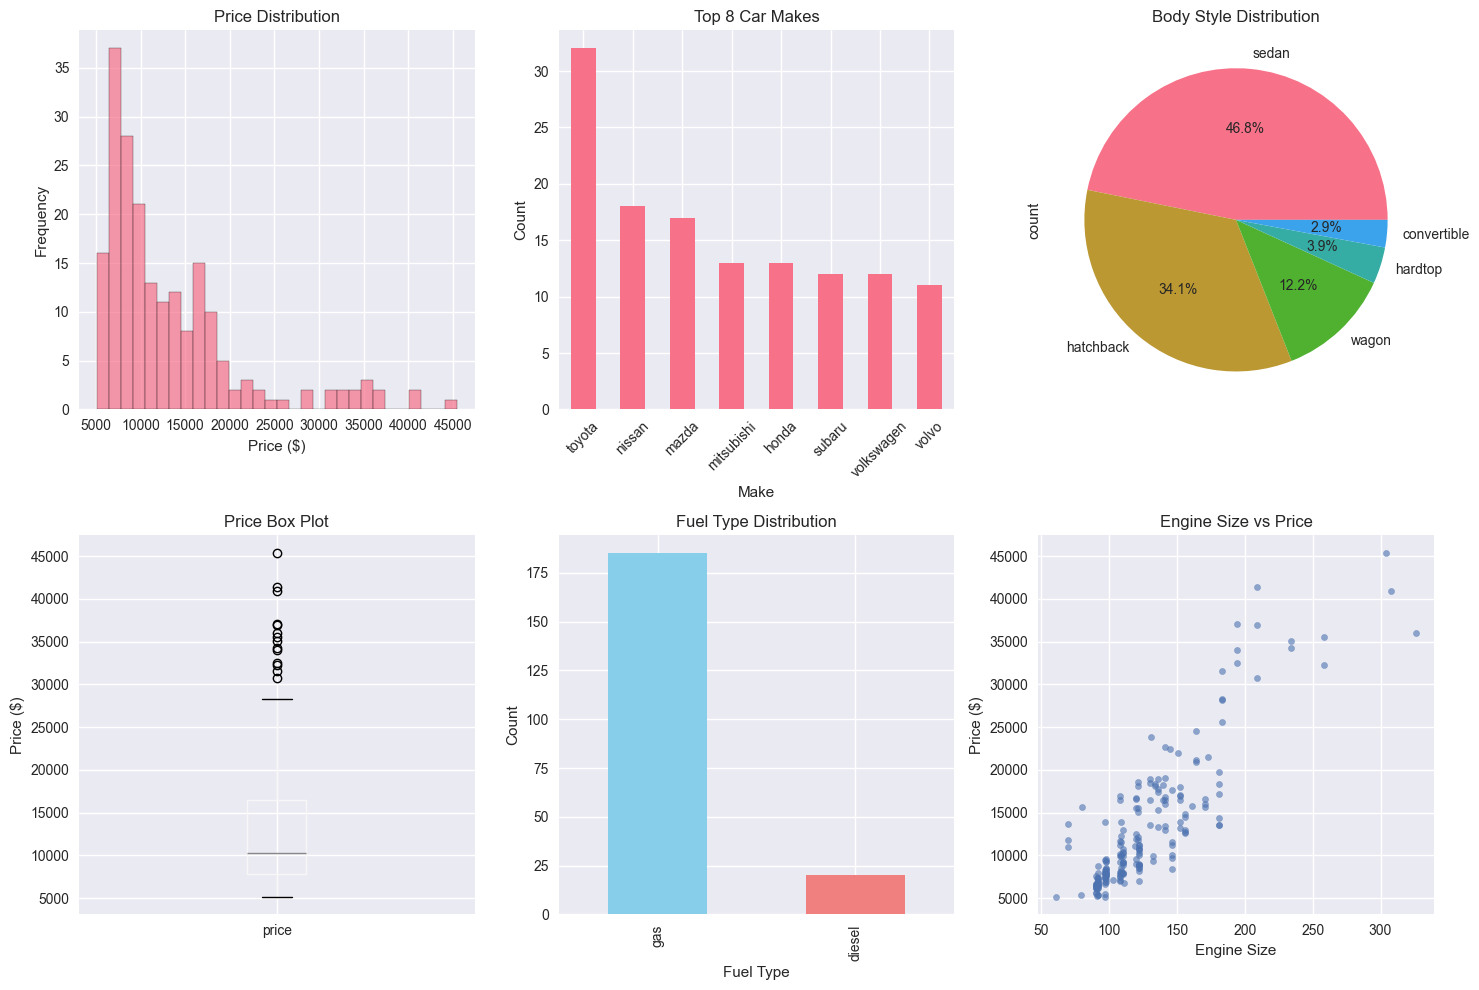

In [7]:
# Basic analysis visualizations
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
df_clean['price'].dropna().hist(bins=30, edgecolor='black', alpha=0.7)
plt.title('Price Distribution')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')

plt.subplot(2, 3, 2)
make_counts = df_clean['make'].value_counts().head(8)
make_counts.plot(kind='bar')
plt.title('Top 8 Car Makes')
plt.xlabel('Make')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.subplot(2, 3, 3)
df_clean['body-style'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Body Style Distribution')

plt.subplot(2, 3, 4)
df_clean.boxplot(column='price', ax=plt.gca())
plt.title('Price Box Plot')
plt.ylabel('Price ($)')

plt.subplot(2, 3, 5)
df_clean['fuel-type'].value_counts().plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Fuel Type Distribution')
plt.xlabel('Fuel Type')
plt.ylabel('Count')

plt.subplot(2, 3, 6)
df_clean.plot.scatter(x='engine-size', y='price', alpha=0.6, ax=plt.gca())
plt.title('Engine Size vs Price')
plt.xlabel('Engine Size')
plt.ylabel('Price ($)')

plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'basic_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

Top 10 correlations with price:
            Feature  Correlation  Abs_Correlation
7       engine-size     0.872335         0.872335
6       curb-weight     0.834415         0.834415
11       horsepower     0.810533         0.810533
16  highway-L/100km     0.801118         0.801118
15     city-L/100km     0.789898         0.789898
4             width     0.751265         0.751265
14      highway-mpg    -0.704692         0.704692
3            length     0.690628         0.690628
13         city-mpg    -0.686571         0.686571
2        wheel-base     0.584642         0.584642


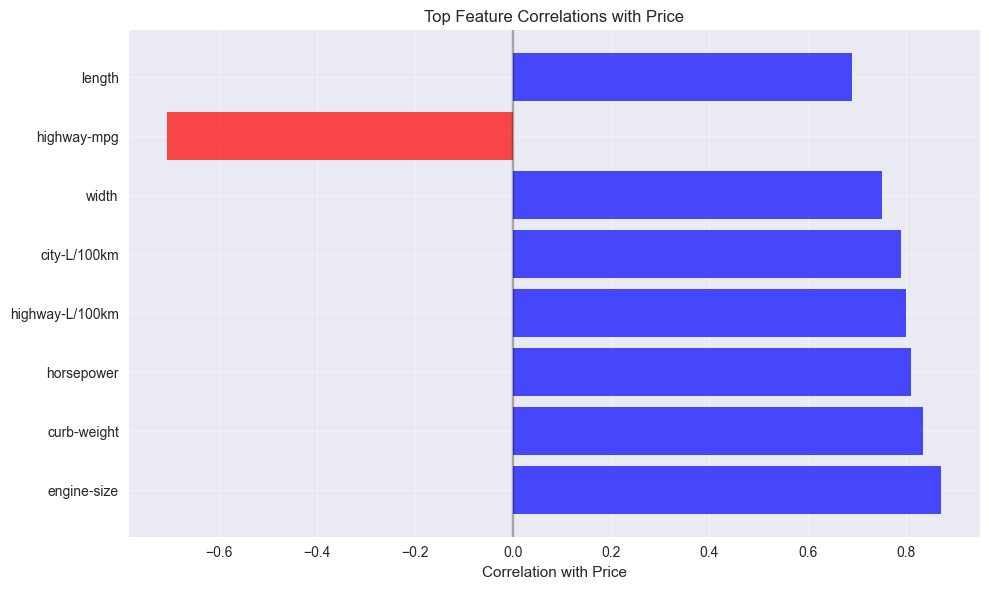

In [8]:
# Correlation analysis with price
price_data = df_clean.dropna(subset=['price'])
correlations = []

for col in numerical_cols:
    if col != 'price' and col in price_data.columns:
        valid_data = price_data[[col, 'price']].dropna()
        if len(valid_data) > 10:
            corr_coef = valid_data[col].corr(valid_data['price'])
            correlations.append({
                'Feature': col,
                'Correlation': corr_coef,
                'Abs_Correlation': abs(corr_coef)
            })

corr_df = pd.DataFrame(correlations).sort_values('Abs_Correlation', ascending=False)

print("Top 10 correlations with price:")
print(corr_df.head(10))

# Visualize top correlations
plt.figure(figsize=(10, 6))
top_corr = corr_df.head(8)
colors = ['red' if x < 0 else 'blue' for x in top_corr['Correlation']]
plt.barh(range(len(top_corr)), top_corr['Correlation'], color=colors, alpha=0.7)
plt.yticks(range(len(top_corr)), top_corr['Feature'])
plt.xlabel('Correlation with Price')
plt.title('Top Feature Correlations with Price')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'price_correlations.png'), dpi=300, bbox_inches='tight')
plt.show()

## 6. Key Business Insights

In [9]:
# Generate business insights
insights = []

# Price insights
avg_price = df_clean['price'].mean()
median_price = df_clean['price'].median()
insights.append(f"Average car price: ${avg_price:,.2f}")
insights.append(f"Median car price: ${median_price:,.2f}")

# Top correlation
if len(corr_df) > 0:
    top_corr = corr_df.iloc[0]
    insights.append(f"Strongest price predictor: {top_corr['Feature']} (r = {top_corr['Correlation']:.3f})")

# Market insights
most_common_make = df_clean['make'].mode()[0]
make_count = df_clean['make'].value_counts().iloc[0]
insights.append(f"Most common make: {most_common_make} ({make_count} cars)")

# Performance insights
avg_horsepower = df_clean['horsepower'].mean()
if not np.isnan(avg_horsepower):
    insights.append(f"Average horsepower: {avg_horsepower:.0f} HP")

print("Key Business Insights:")
print("=" * 50)
for i, insight in enumerate(insights, 1):
    print(f"{i}. {insight}")

Key Business Insights:
1. Average car price: $13,207.13
2. Median car price: $10,295.00
3. Strongest price predictor: engine-size (r = 0.872)
4. Most common make: toyota (32 cars)
5. Average horsepower: 104 HP


## 7. Data Export

In [10]:
# Save processed datasets
print("Saving processed data...")

# Save cleaned dataset
df_clean.to_csv(os.path.join(data_dir, 'automobile_data_cleaned.csv'), index=False)

# Save correlation analysis
corr_df.to_csv(os.path.join(reports_dir, 'price_correlations.csv'), index=False)

# Save summary statistics
df_clean.describe().to_csv(os.path.join(reports_dir, 'numeric_summary.csv'))

print("Files saved to organized directories:")
print(f"- Processed data: {data_dir}/")
print(f"- Reports: {reports_dir}/")
print(f"- Visualizations: {viz_dir}/")

Saving processed data...
Files saved to organized directories:
- Processed data: E:\PythonProjects\PA-Projects\Automobile_Data_Wrangling_Analysis\results\processed_data/
- Reports: E:\PythonProjects\PA-Projects\Automobile_Data_Wrangling_Analysis\results\reports/
- Visualizations: E:\PythonProjects\PA-Projects\Automobile_Data_Wrangling_Analysis\results\visualizations/


## Analysis Complete!

This comprehensive automobile data analysis has provided:

### Data Quality
- Successfully processed 205 automobile records
- Handled missing values and data type conversions
- Created meaningful feature categories

### Key Findings
- Identified strongest predictors of automobile price
- Analyzed market distribution across makes and body styles
- Quantified performance relationships

### Outputs
All results are organized in the `results/` directory:
- **visualizations/**: Charts and plots
- **processed_data/**: Clean datasets
- **reports/**: Analysis summaries